In [121]:
import sys 

sys.path.append("/home/davi/PycharmProjects/Reconhecimento-de-Padroes")

from numpy import linspace, random, array, concatenate, dot, mean, zeros, ones, ravel, exp
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import datetime

import cvxopt
import cvxopt.solvers

test_size = .2

In [122]:
noise = random.rand(100)*4.0
x = linspace(0.1,50., 100)
alpha = random.uniform(0, 1)
b = random.uniform(-1,1)
y = (alpha*x + b) - noise
print("expected: ", alpha, b)

# plt.plot(x, y, 'r+')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

x = array(x, ndmin=2, dtype=float)
y = array(y, ndmin=2, dtype=float)

data = concatenate((x, y), axis=0).T
random.shuffle(data)

expected:  0.2829603536373245 -0.5486097852848968


In [123]:
def train(x_train, y_train, form=None, max_iter=None, learning_rate=None):
    if form is None:
        return "Error"
    
    forms = {"normal equation": normal_equation,
             "gradient descent": gradient_descent,
             "kernel": kernel}
    
    
    return forms[form](x_train, y_train, max_iter, learning_rate)

In [124]:
def normal_equation(x_train, y_train, form):
    pseudo_inverse = dot(inv(dot(x_train.T, x_train)), x_train.T)
    weights = dot(pseudo_inverse,y_train)
    
    return weights
    

In [125]:
def gradient_descent(x_train, y_train, max_iter, learning_rate):
    number_lines, number_columns = x_train.shape
    weights = zeros((number_columns, 1))
    
    for epoch in range(max_iter):
        for point in range(number_lines):
            y_output = dot(x_train[point], weights)
            error = y_train[point] - y_output
            aux = array(learning_rate*(x_train[point]*error), ndmin=2)
            weights += aux.T
        
    return weights

In [126]:
def kernel(x_train, y_train, max_iter, learning_rate):
     
    number_lines, number_columns = x_train.shape
    gausian = zeros((number_lines, number_lines))
    for i in range(number_lines):
        for j in range(number_lines):
            gausian[i][j] = dot(x_train[i]- x_train[j],(x_train[i]- x_train[j]).T) 
    
    # print(gausian)
    sigma = 1
    adjust = -1./(sigma**2)
    gausian_kernel = inv(exp(adjust*gausian))
    poynomial_kernel = (dot(x_train, x_train.T)+1)**2
    k = poynomial_kernel
    alphas = dot(inv(k),  y_train)
    
    return gausian_kernel



In [127]:
def calculate_kernel(x_train, x_test):
    
    number_lines, number_columns = x_test.shape
    gausian = zeros((x_train.shape[0], x_test.shape[0]))
    for i in range(x_test.shape[0]):
        for j in range(x_train.shape[0]):
            gausian[j][i] = dot(x_train[j]- x_test[i],(x_train[j]- x_test[i]).T) 
    
    # print(gausian)
    sigma = 1
    adjust = -1./(sigma**2)
    gausian_kernel = exp(adjust*gausian)
    poynomial_kernel = (dot(x_test, x_train.T)+1)**2
    
    return gausian_kernel

def test(x_test, y_test, weights):
    
    number_examples = x_test.shape[0]
    output = dot(x_test, weights)
    error = sum((y_test-output)**2)*(1./(number_examples*1.0))
    
    return error


In [128]:
def test_kernel(x_test, x_train, y_test, alphas, weights, bias):
     
     # number_lines_t, number_columns_t = x_train.shape
     # number_lines, number_columns = x_test.shape
     # gausian = zeros((number_lines, number_lines))
     # for i in range(number_lines):
     #     for j in range(number_columns_t):
     number_examples = x_test.shape[0]
     gausian = calculate_kernel(x_train, x_test)
     y_output = dot(gausian, alphas)
     error = sum((y_test-y_output)**2)*(1./(number_examples*1.0))
     
    
     return error
    

# Primeiro utilizado o modelo com a formula fechada

In [129]:
x = array(data[:, 0], ndmin=2).T
y = array(data[:, 1], ndmin=2).T

Media do erro:  3.277454452627193
Media de tempo:  80.2
Numero de dados de treino:  80


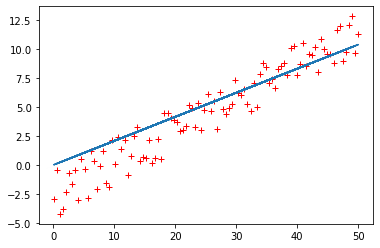

In [130]:
all_errors = []
all_times = []
for realization in range(10):
    
     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
     start = datetime.datetime.now()
     weights = normal_equation(x_train, y_train, 'normal equation')
     final = datetime.datetime.now()
     time = (final-start).microseconds
     error = test(x_test, y_test, weights)
     all_errors.append(error)
     all_times.append(time)
     
print("Media do erro: ",mean(all_errors))
print("Media de tempo: ", mean(all_times))
print("Numero de dados de treino: ", x_train.shape[0])
plt.plot(x, y, 'r+')
plt.plot(x, dot(x, weights))
plt.show()   
    
    

# Agora utilizando otimização com gradiente descendente


Media do erro:  10.877881671119901
Media de tempo:  503343.3
Numero de dados de treino:  80


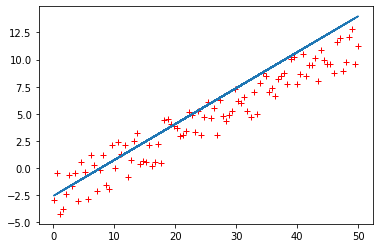

In [131]:

bias = ones((x.shape[0], 1))
x_new = concatenate((bias, x), axis=1)

all_errors = []
all_times = []
for realization in range(10):
    
     x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=test_size)
     start = datetime.datetime.now()
     weights = train(x_train, y_train, max_iter=1000, learning_rate=1e-3, form="gradient descent")
     final = datetime.datetime.now()
     time = (final-start).microseconds
     error = test(x_test, y_test, weights)
     all_errors.append(error)
     all_times.append(time)
     
print("Media do erro: ",mean(all_errors))
print("Media de tempo: ", mean(all_times))
print("Numero de dados de treino: ", x_train.shape[0]) 
   
plt.plot(x, y, 'r+')
plt.plot(x, dot(x_new, weights))
plt.show()   
    

# Agora utilizando o metodo de regressão com kernel


In [132]:
all_errors = []
all_times = []
for realization in range(10):
    
    x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=test_size)
    start = datetime.datetime.now()
    alphas  = train(x_train, y_train, form='kernel')
    final = datetime.datetime.now()
    time = (final-start).microseconds
    # print(weights)
    error = test_kernel(x_test, x_train,y_test, alphas, None, bias)
    # print(error)
    all_errors.append(error)
    all_times.append(time)
    
print("Media do erro: ",mean(all_errors))
print("Media de tempo: ", mean(all_times))
print("Numero de dados de treino: ", x_train.shape[0]) 
   

# plt.plot(x, y, 'r+')
# aux = dot(weights, x.T)
# bias = y - aux.T 
# plt.plot(x, aux.T)
# plt.show()  

ValueError: shapes (80,20) and (80,80) not aligned: 20 (dim 1) != 80 (dim 0)